In [259]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import requests
import os
import seaborn as sns
import sklearn

In [307]:
# Compare each metric for each network
m = pd.read_pickle('network-metrics-data/mentions.pkl')
l = pd.read_pickle('network-metrics-data/likes.pkl')
f = pd.read_pickle('network-metrics-data/follows.pkl')

In [308]:
# Merge all features on twitter id
rn = ['follow_' + nm for nm in f.columns]
f.columns = rn
f.rename(columns={
    'follow_twitter_id': 'twitter_id'
}, inplace=True)

rn = ['likes_' + nm for nm in l.columns]
l.columns = rn
l.rename(columns={
    'likes_twitter_id': 'twitter_id'
}, inplace=True)

rn = ['mentions_' + nm for nm in m.columns]
m.columns = rn
m.rename(columns={
    'mentions_twitter_id': 'twitter_id'
}, inplace=True)

df = f.merge(l, on='twitter_id').merge(m, on='twitter_id').drop(columns=['follow_label', 'mentions_label'])

df.rename(columns={
    'likes_label': 'label'
}, inplace=True)

In [309]:
print(f'Number of data points : {df.shape[0]}')

Number of data points : 52


In [310]:
df.label.value_counts()

bot      26
human    26
Name: label, dtype: int64

In [265]:
from sklearn.decomposition import PCA

# classification
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [311]:
df.loc[df.label == 'bot', 'label'] = 0
df.loc[df.label == 'human', 'label'] = 1

In [313]:
df = df.drop(columns='twitter_id')

In [270]:
from sklearn.utils import resample

df_majority = df[df.label==1]
df_minority = df[df.label==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=260,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()

0    260
1     26
Name: label, dtype: int64

In [ ]:
df = df_upsampled

In [314]:
from sklearn import preprocessing
outcome_col = 'label'

y = np.array(df[outcome_col])
X = np.array(df.drop(columns = [outcome_col]))

# Preprocess
X = preprocessing.StandardScaler().fit_transform(X)
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

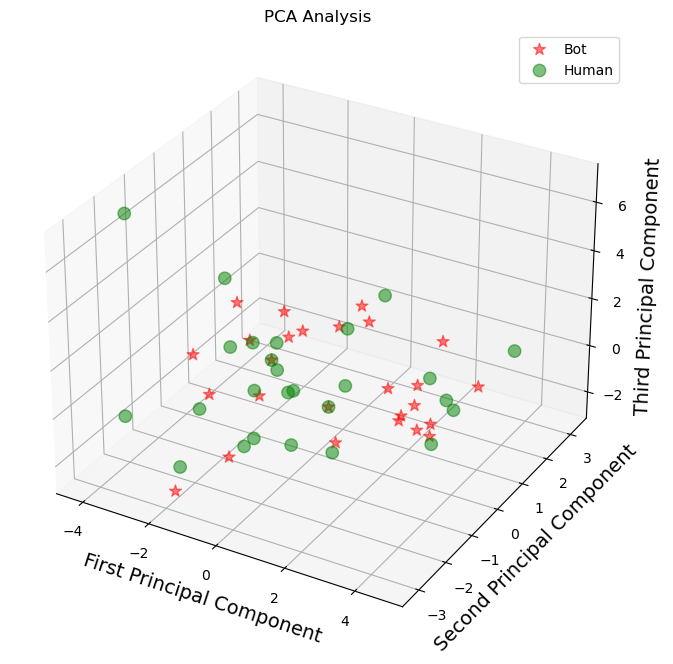

In [315]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X) 
X_pca = pca.transform(X) 

Xax = X_pca[:,0]
Yax = X_pca[:,1]
Zax = X_pca[:,2]


cdict = {0:'red',1:'green'}
labl = {0:'Bot',1:'Human'}
marker = {0:'*',1:'o'}
alpha = {0:.5, 1:.5}

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
     ix=np.where(y==l)
     ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=80,
               label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)
plt.title('PCA Analysis')

ax.legend()
plt.show()

In [316]:
ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio

array([0.6 , 0.23, 0.17])

In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [318]:
print("Test Examples:", X_test.shape[0])
print("Test Features:", X_test.shape[1])

print("Train Examples:", X_train.shape[0])
print("Train Features:", X_train.shape[1])

Test Examples: 16
Test Features: 24
Train Examples: 36
Train Features: 24


In [319]:
def calc_accuracy(predicted_labels, true_labels):
    total_count = len(true_labels)
    correct_count = 0
    for pred, true in zip(predicted_labels, true_labels):
        if pred == true:
            correct_count+=1
    
    return correct_count/total_count

In [323]:
clf = RandomForestClassifier(max_depth=4, n_estimators=10, max_features=1)

In [320]:
names = ["Nearest Neighbors", "Logistic Regression", "Decision Tree", "Random Forest", "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(4),
    LogisticRegression(random_state=0),
    DecisionTreeClassifier(max_depth=4),
    RandomForestClassifier(max_depth=4, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB()
    ]

kf = KFold(len(X_train), shuffle=False, random_state=None)
valid_accuracy = []
train_accuracy = []

# iterate over classifiers -- with cross-validation
for name, clf in zip(names, classifiers):
    for train_index, valid_index in kf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

        # Fit classifier
        clf.fit(X_train_fold, y_train_fold)

        # Collect accuracy on test fold
        train_accuracy.append(clf.score(X_train_fold, y_train_fold))

        valid_accuracy.append(clf.score(X_valid_fold, y_valid_fold))

    mean_train_acc = np.mean(train_accuracy)
    mean_valid_acc = np.mean(valid_accuracy)

    print('------------')
    print('Model: ' + str(name))
    print('Train Accuracy')
    print(mean_train_acc)
    print()
    print('Valid Accuracy')
    print(mean_valid_acc)
    print()

------------
Model: Nearest Neighbors
Train Accuracy
0.5904761904761906

Valid Accuracy
0.4722222222222222

------------
Model: Logistic Regression
Train Accuracy
0.7063492063492062

Valid Accuracy
0.4583333333333333

------------
Model: Decision Tree
Train Accuracy
0.7952380952380954

Valid Accuracy
0.5185185185185185

------------
Model: Random Forest
Train Accuracy
0.8246031746031744

Valid Accuracy
0.5138888888888888

------------
Model: Naive Bayes
Train Accuracy
0.8596825396825396

Valid Accuracy
0.5333333333333333



In [281]:
# Without k-fold cross validation
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print('-------')
    print(name)
    print('Train Accuracy: ' + str(clf.score(X_train, y_train)))
    print('Validation Accuracy: ' + str(clf.score(X_test, y_test)))

-------
Nearest Neighbors
Train Accuracy: 0.5833333333333334
Validation Accuracy: 0.5
-------
Logistic Regression
Train Accuracy: 0.8333333333333334
Validation Accuracy: 0.4375
-------
Decision Tree
Train Accuracy: 0.9722222222222222
Validation Accuracy: 0.4375
-------
Random Forest
Train Accuracy: 0.9166666666666666
Validation Accuracy: 0.5
-------
Naive Bayes
Train Accuracy: 1.0
Validation Accuracy: 0.375


In [282]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

In [297]:
# Delve into Random Forest

forest = DecisionTreeClassifier()#RandomForestClassifier(random_state = 1)
modelF = forest.fit(X_train, y_train)
y_predF = modelF.predict(X_test)

#n_estimators = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 25, 30, 40]
max_depth = [2, 3, 4, 5, 6, 7, 8, 15]
min_samples_split = [2, 3, 4, 5, 10]
min_samples_leaf = [1, 2, 5, 6, 7] 

hyperF = dict(max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)
# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

# forestVC = RandomForestClassifier(random_state = 1,
#                                   n_estimators = 750,
#                                   max_depth = 15, 
#                                   min_samples_split = 5,  min_samples_leaf = 1) 
# modelVC = forestVC.fit(X_train, y_train) 
# y_predVC = modelVC.predict(X_test)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [298]:
bestF.best_params_

{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 3}

In [301]:
forest = DecisionTreeClassifier(max_depth=4)#RandomForestClassifier(random_state = 1)
modelF = forest.fit(X_train, y_train)
y_predF = modelF.predict(X_test)

In [303]:
calc_accuracy(y_predF, y_test)

0.375

In [299]:
# DT
bestF.best_params_

{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 3}

In [300]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    #mape = 100 * np.mean(errors / test_labels)
    accuracy = calc_accuracy(predictions, test_labels) * 100
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

bestF.best_estimator_.fit(X_train, y_train)
base_accuracy = evaluate(bestF.best_estimator_, X_test, y_test)

Model Performance
Average Error: 0.6250 degrees.
Accuracy = 37.50%.


follow_indeg: 0.04915155782432669
follow_outdeg: 0.05362092546182935
follow_clustercoeff: 0.0002829854969932809
follow_pagerank: 0.028021020492138782
follow_indeg_A1: 0.11394930832578676
follow_outdeg_A1: 0.009353052404105885
follow_indeg_A2: 0.024156213586441967
follow_outdeg_A2: 0.03829476827287902
likes_indeg: 0.012773818974123491
likes_outdeg: 0.03434336525307798
likes_clustercoeff: 0.014210526315789476
likes_pagerank: 0.06409395340668328
likes_indeg_A1: 0.11913232708641511
likes_outdeg_A1: 0.0
likes_indeg_A2: 0.06739618705293376
likes_outdeg_A2: 0.0
label: 0.08520278794053754
mentions_indeg: 0.03087667006259418
mentions_outdeg: 0.054596912725961275
mentions_clustercoeff: 0.08961785620223568
mentions_pagerank: 0.04567897719533742
mentions_indeg_A1: 0.0
mentions_outdeg_A1: 0.0652467859198091
mentions_indeg_A2: 0.0


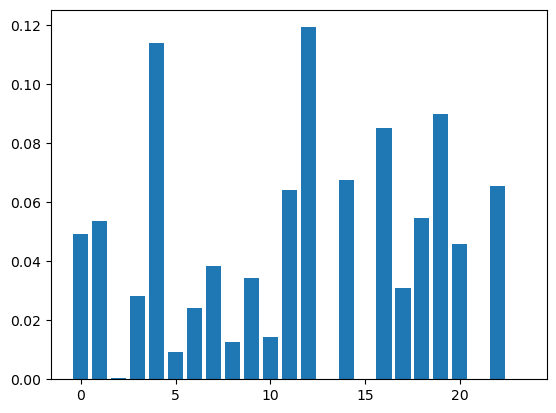

In [329]:
# Logistic Regression 
#importance = model.coef_[0]
fi = clf.feature_importances_
fi = [abs(i) for i in fi]
for metric, importance in zip(df.columns[0:-1], fi):
    print(metric + ': ' + str(importance))
    
plt.bar([x for x in range(len(fi))], fi)
plt.show()

follow_indeg: 0.3872340425531915
follow_outdeg: 0.0
follow_clustercoeff: 0.0
follow_pagerank: 0.0
follow_indeg_A1: 0.0
follow_outdeg_A1: 0.0
follow_indeg_A2: 0.0
follow_outdeg_A2: 0.0
likes_indeg: 0.0
likes_outdeg: 0.0
likes_clustercoeff: 0.0
likes_pagerank: 0.0
likes_indeg_A1: 0.0
likes_outdeg_A1: 0.0
likes_indeg_A2: 0.0
likes_outdeg_A2: 0.0
label: 0.32826747720364746
mentions_indeg: 0.0
mentions_outdeg: 0.28449848024316104
mentions_clustercoeff: 0.0
mentions_pagerank: 0.0
mentions_indeg_A1: 0.0
mentions_outdeg_A1: 0.0
mentions_indeg_A2: 0.0


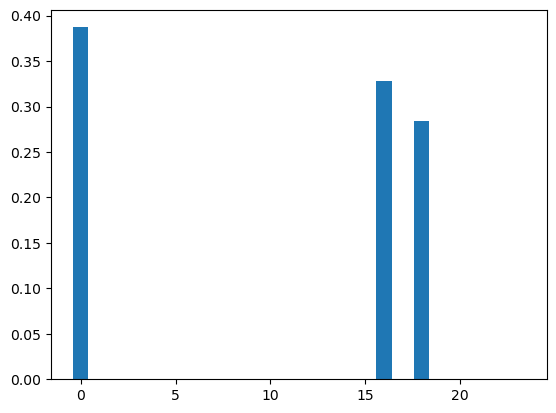

In [289]:
fi = bestF.best_estimator_.feature_importances_
for metric, importance in zip(df.columns[0:-1], fi):
    print(metric + ': ' + str(importance))
    
plt.bar([x for x in range(len(fi))], fi)
plt.show()

In [296]:
bestF.best_estimator_

DecisionTreeClassifier(max_depth=2, min_samples_split=3)

In [290]:
clf = bestF.best_estimator_

In [331]:
y_preds = clf.predict(X_test)

# --classification report --
d = metrics.classification_report(y_test, y_preds, output_dict=True)

In [332]:
t = pd.DataFrame.from_dict(d)
t.rename(columns={
    '0': 'bot',
    '1': 'human'
})

,bot,human,accuracy,macro avg,weighted avg
precision,0.428571,0.444444,0.4375,0.436508,0.436508
recall,0.375000,0.500000,0.4375,0.437500,0.437500
f1-score,0.400000,0.470588,0.4375,0.435294,0.435294
support,8.000000,8.000000,0.4375,16.000000,16.000000


In [333]:
print('label: 0')
print(d['0'])
print()
print('label: 1')
print(d['1'])
print()
print('accuracy')
print(d['accuracy'])
print()
print('macro avg')
print(d['macro avg'])
print()
print('weighted avg')
print(d['weighted avg'])

label: 0
{'precision': 0.42857142857142855, 'recall': 0.375, 'f1-score': 0.39999999999999997, 'support': 8}

label: 1
{'precision': 0.4444444444444444, 'recall': 0.5, 'f1-score': 0.47058823529411764, 'support': 8}

accuracy
0.4375

macro avg
{'precision': 0.4365079365079365, 'recall': 0.4375, 'f1-score': 0.43529411764705883, 'support': 16}

weighted avg
{'precision': 0.4365079365079365, 'recall': 0.4375, 'f1-score': 0.43529411764705883, 'support': 16}


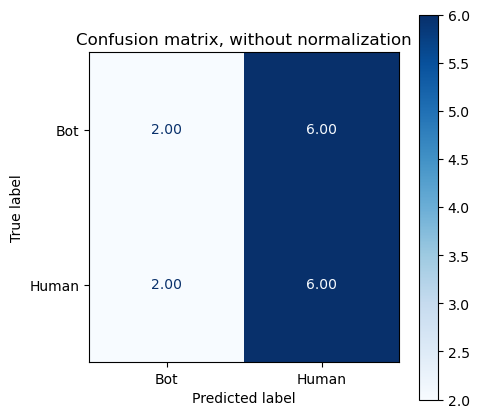

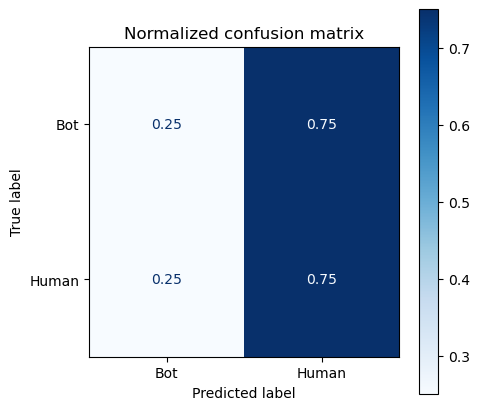

In [334]:
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
# tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
# print((tn, fp, fn, tp))

# Plot non-normalized confusion matrix
clf.fit(X_train, y_train)
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['Bot', 'Human'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,
                                ax=ax, values_format = '.2f')
    plt.title(title)
    
#plt.show()